# Modeling California Wildfires 1992 - 2020

In [1]:
# Import Libraries

# ML Basics plus sqlite3
import pandas as pd
import numpy as np
import sqlite3

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Geocoding Libraries
from shapely.geometry import Point
import geopandas as gpd
from geopy.geocoders import Nominatim

# Sci-Kit Learn Libraries
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Keras/Tensorflow
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import Accuracy

# Misc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load our dataset, created during cleaning phase.
fires_df = pd.read_csv('Data/Updated CA Wildfire Database.csv')

# Drop features we don't need for modeling, do some renaming
fires_df = fires_df[[
       'NWCG_REPORTING_UNIT_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'NWCG_GENERAL_CAUSE',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'FIPS_NAME']]

# and rename some features to be friendlier
fires_df.rename(columns={'FIPS_NAME':'COUNTY','NWCG_REPORTING_UNIT_NAME':'WILDLAND_NAME','NWCG_GENERAL_CAUSE':'CAUSE'}, inplace= True)

# # Split DISCOVERY_DATE into MM/DD, we already have FIRE_YEAR for YYYY
fires_df[['DISCOVERY_MONTH','DISCOVERY_DAY','DISCOVERY_YEAR']] = fires_df.DISCOVERY_DATE.str.split('/', expand= True)

# #Cast above as INT
fires_df[['DISCOVERY_MONTH','DISCOVERY_DAY','DISCOVERY_YEAR']] = fires_df[['DISCOVERY_MONTH','DISCOVERY_DAY','DISCOVERY_YEAR']].astype(int)

# Encode FIRE_SIZE_CLASS using Ordinal Encoder
encoder = OrdinalEncoder()
fires_df['FIRE_SIZE_CLASS'] = encoder.fit_transform(fires_df[['FIRE_SIZE_CLASS']])


In [3]:
# Count of fires by year
count_by_year = fires_df.groupby(['FIRE_YEAR'])[['FIRE_SIZE']].count().reset_index()
# Sum of damage by year
damage_by_year = fires_df.groupby(['FIRE_YEAR'])[['FIRE_SIZE']].sum().reset_index()
# Average damage per year
avg_dmg_by_year = fires_df.groupby(['FIRE_YEAR'])[['FIRE_SIZE']].mean().reset_index()

Let's see if we can build a reasonably accurate Linear Regression model to predict acres burned per year...

In [4]:
# Assign features and target
X = damage_by_year.drop(columns='FIRE_SIZE')
y = damage_by_year.FIRE_SIZE
# Cross Validation with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 20)
# Our VERY basic Regression Model
lr = LinearRegression()
# Fit the model
lr.fit(X_train, y_train)
# Makes some prediction on our test set
lr_preds = lr.predict(X_test)
# Measure the Mean Squared Error of our predictions against "y-true"
mse = mean_squared_error(y_test, lr_preds)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1423963979870.2073


In [5]:
damage_by_year.corr()

,FIRE_YEAR,FIRE_SIZE
FIRE_YEAR,1.000000,0.475766
FIRE_SIZE,0.475766,1.000000


Our model is impressively awful! While there is definite correlation between calendar year, calendar year is not an accurate predictor of wildfire size in and of itself. How do Lasso and Ridge Regression perform with this data set?

In [6]:
# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)
mse = mean_squared_error(y_test, lasso_preds)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1423963991151.8738


In [7]:
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)
mse = mean_squared_error(y_test, ridge_preds)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1424123205636.114


At this point, I think it safe to say that Linear Regression based on a simple dataset of year and fire size is not a very useful model. Does a Keras Time Series Model perform any better?

In [8]:
# Timeseries with Keras

# Discover_Date to datetime object
fires_df['DD_TSERIES'] = pd.to_datetime(fires_df['DISCOVERY_DATE'])
# Use Year/Month for our Time Series
fires_df['DD_TSERIES'] = fires_df['DD_TSERIES'].dt.strftime('%Y-%m')

# Create a new df for time series
ts_fires_df = fires_df[['DD_TSERIES', 'FIRE_SIZE']]

# Set DD_TSERIES as index, sort, group by monthly average fire size
ts_fires_df.set_index('DD_TSERIES', inplace= True)
ts_fires_df.sort_index(ascending= True, inplace= True)
ts_fires_df = ts_fires_df.groupby(ts_fires_df.index)[['FIRE_SIZE']].mean()
ts_fires_df

,FIRE_SIZE
DD_TSERIES,
1992-01,2.416304
1992-02,4.175926
1992-03,39.279167
1992-04,28.434363
1992-05,8.992681
...,...
2020-08,1893.376953
2020-09,1018.627920
2020-10,38.060941


In [9]:
# Create sequences from our dataframe
def create_sequences(ts_fires_df, seq_length):
    xs = []
    ys = []
    for i in range(len(ts_fires_df)-seq_length-1):
        x = ts_fires_df[i:(i+seq_length)]
        y = ts_fires_df[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10 
X, y = create_sequences(ts_fires_df['FIRE_SIZE'].values, seq_length)

In [10]:
# Model architecture leveraging LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

# Compile model with Accuracy as our metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Accuracy()])

In [11]:
# Reshape data for (Sample, Time Steps, Features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train the model
history = model.fit(X, y, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0000e+00 - loss: 544.3226 - val_accuracy: 0.0000e+00 - val_loss: 1052.9940
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 200.2916 - val_accuracy: 0.0000e+00 - val_loss: 586.8107
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: -237.1960 - val_accuracy: 0.0000e+00 - val_loss: 121.6580
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: -394.6903 - val_accuracy: 0.0000e+00 - val_loss: -933.6338
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: -472.5327 - val_accuracy: 0.0000e+00 - val_loss: -1038.6803
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: -567.5804 - val_accuracy: 0.0000e+00 - val_loss: -1232.1257
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: -593.9207 - val_accuracy: 0.0000e+00 - val_loss: -1249.0548
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━

In [12]:
# Model evaluation

# Cross Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)

# Reshape X_train and X_test
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model on the training data
model.fit(X_train, y_train, epochs=10, validation_split=0.2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


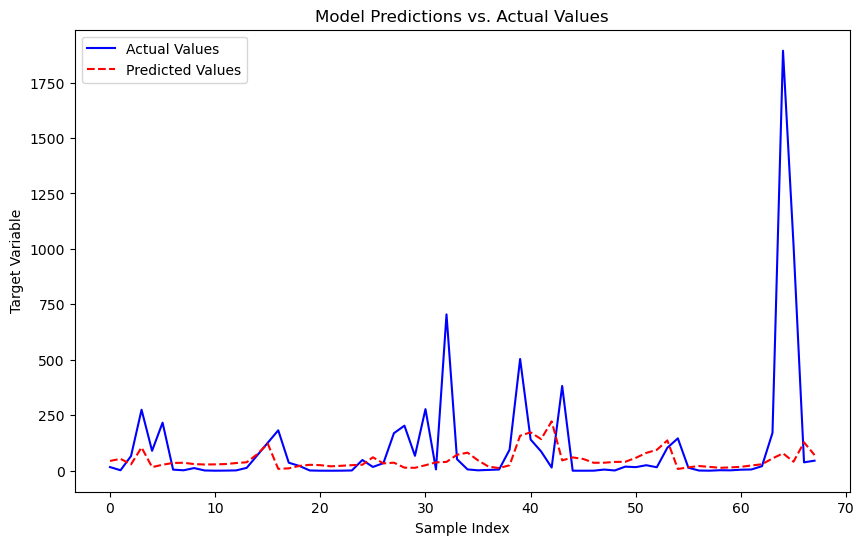

In [14]:
# Make predictions on the test data
test_predictions = model.predict(X_test)
test_predictions = test_predictions.flatten()  # Flatten the array if needed

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(test_predictions, label='Predicted Values', color='red', linestyle='--')
plt.title('Model Predictions vs. Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

In [15]:
# Model evaluation metrics
model.evaluate(X, y)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22403.6172


22403.6171875

There is some semblance of a working model here, albeit a very innaccurate one. While an interesting exercise, I don't think it is of much use from a practical perspective.

Are there any clusters of FIRE_SIZE_CLASS = 6.0, the most severe fire size class? Deploy DBSCAN to answer this question.

In [16]:
# Build a df with FIRE_SIZE_CLASS = 6.0 and those fire's Lat/Lon
big_fires = fires_df[fires_df['FIRE_SIZE_CLASS'] == 6.0][['LONGITUDE', 'LATITUDE']]
# Create an array to feed to DBSCAN
X = np.array(big_fires)

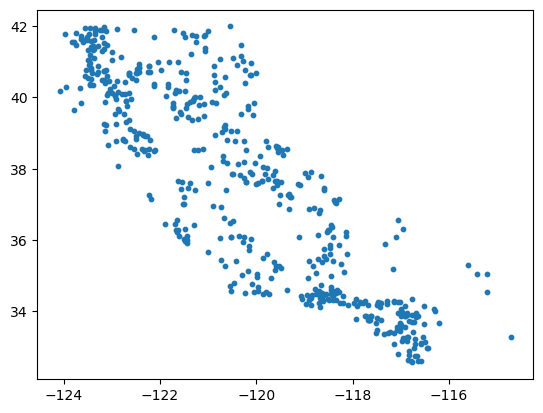

In [17]:
# Quick visualization of FIRE_SIZE_CLASS = 6.0
plt.scatter(X[:, 0], X[:, 1], s=10);

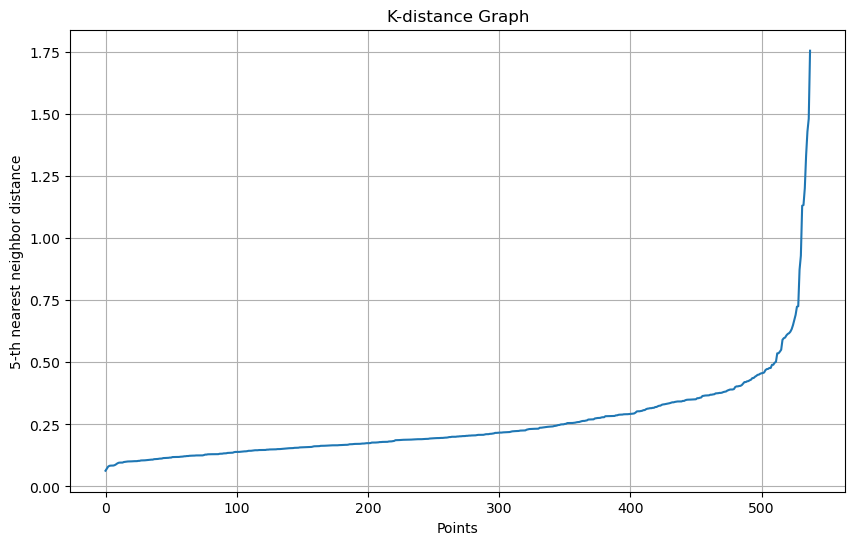

In [18]:
# Code borrowed from Codecamp to figure out the 'best' epsilon.
# Function to plot k-distance graph
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.grid()
    plt.show()
# Plot k-distance graph
plot_k_distance_graph(X, k=5)

The "elbow" of the plot is at 0.50 approximately, use that for "epsilon" value.

In [19]:
# Instantiate our DBSCAN object with initial settings, min_samples set to 4X the number of features, rounded up to next odd number
db = DBSCAN(eps=0.5, min_samples=9).fit(X)

# We'll use these labels for visualization of our results
labels = db.labels_

# Identify number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

Estimated number of clusters: 6
Estimated number of noise points: 25


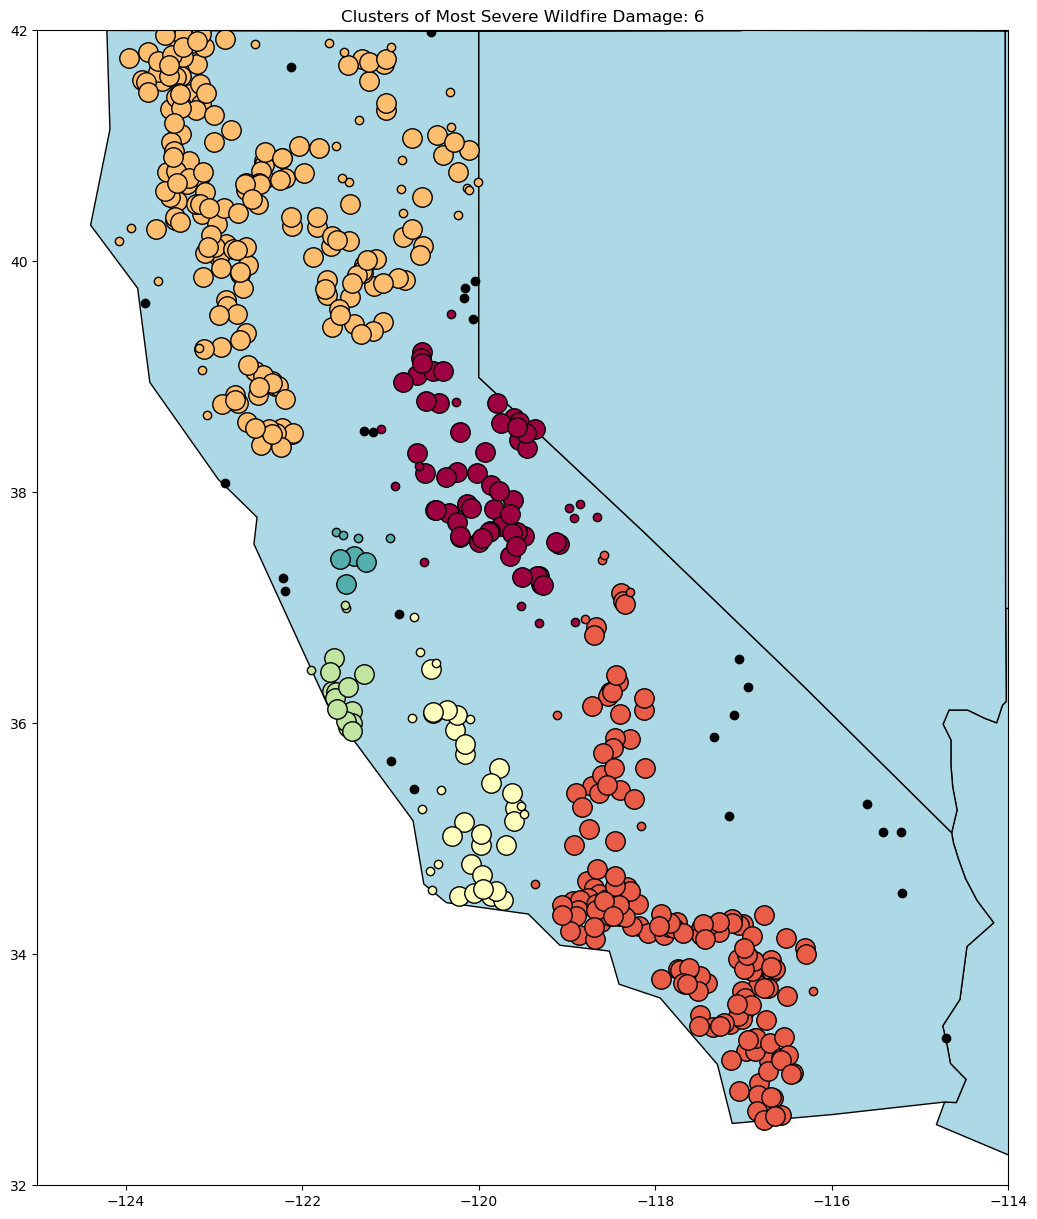

In [20]:
# Visualize the cluster against the State map
# Create geometry column
geometry = [Point(xy) for xy in zip(fires_df.LONGITUDE, fires_df.LATITUDE)]
gdf = gpd.GeoDataFrame(fires_df, geometry=geometry)

# Load world map
world = gpd.read_file('Data/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp')

# Create the geo bounding box for our basemap
bounding_box = [-125, 32, -114, 42] 
region = world.cx[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3]]

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
fig, ax = plt.subplots(figsize=(15, 15)) 
region.plot(ax=ax, color='lightblue', edgecolor='black') 
ax.set_xlim(bounding_box[0], bounding_box[2]) 
ax.set_ylim(bounding_box[1], bounding_box[3]) 
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
plt.title(f'Clusters of Most Severe Wildfire Damage: {n_clusters}')
plt.show();

With these settings (eps=0.5, min_samples=9), DBSCAN creates six (6) clusters of lat/lon where the largest fires burn. When visualized against a map of the state of California, it's stark how much of the state is prone to large-scale destructive wildfire. This model is very sensitive to the min_samples size, which brings into question the validity of these clusters. For instance, with a min_sample size of 2X + 1 the number of features (five(5)), our model builds two(2) clusters, rather than six(6), which isn't very useful. 

Try to predict fire cause based on day of year, lat/lon and size. However, the second leading cause of wildfire is essentially "unknown" which is not a very useful prediction. Drop records with an "unknown" cause and see if it helps our model make useful predictions.

In [21]:
# Drop rows with missing cause
tmp_fires_df = fires_df[fires_df.CAUSE != 'Missing data/not specified/undetermined']
tmp_fires_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156618 entries, 0 to 251865
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   WILDLAND_NAME    156618 non-null  object 
 1   FIRE_YEAR        156618 non-null  int64  
 2   DISCOVERY_DATE   156618 non-null  object 
 3   DISCOVERY_DOY    156618 non-null  int64  
 4   CAUSE            156618 non-null  object 
 5   FIRE_SIZE        156618 non-null  float64
 6   FIRE_SIZE_CLASS  156618 non-null  float64
 7   LATITUDE         156618 non-null  float64
 8   LONGITUDE        156618 non-null  float64
 9   COUNTY           156618 non-null  object 
 10  DISCOVERY_MONTH  156618 non-null  int64  
 11  DISCOVERY_DAY    156618 non-null  int64  
 12  DISCOVERY_YEAR   156618 non-null  int64  
 13  DD_TSERIES       156618 non-null  object 
dtypes: float64(4), int64(5), object(5)
memory usage: 17.9+ MB


In [22]:
# Prepare df for modeling
X = tmp_fires_df[['DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE']]
y = tmp_fires_df.CAUSE
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instantiate RFC object
rfc = RandomForestClassifier()

 #Fit the model
rfc.fit(X_train, y_train)

# Score the model
y_pred = rfc.predict(X_test)
accuracy_score(y_test, y_pred)

0.5448601711148001

Randomly guessing a cause for any particular wildfire incident has a 8.3% chance of being correct. As such, the baseline RFC model is significantly more accurate than random guessing. Use GridSearchCV to tune RFC hyperparameters and see if it can further improve accuracy. 

In [23]:
# Hyperparams param grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate our gridsearch object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test Set Accuracy:", accuracy)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Test Set Accuracy: 0.5561486400204316


There is marginal improvement with model tuning. Try a Support Vector Classifier and see how it performs relative to our RFC.

In [24]:
# Instantiate the model
svc = svm.SVC()
# Train the model
svc.fit(X_train, y_train)
# Score the model
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.2897203422296003

Looks like random forest is the better classifier. Ammend the dataframe and fill the "Unkown" cause with imputed Cause Predictions and use that to see how accurately it can predict Fire Size:

In [25]:
# List of Causes = Missing data/etc.
filtered_df = fires_df[fires_df['CAUSE'] == 'Missing data/not specified/undetermined']
# Loop through the dataframe and replace "Missing data..." wuth our RFC prediction
for index, row in filtered_df.iterrows():
    pred = rfc.predict([[fires_df['DISCOVERY_DOY'][index], fires_df['FIRE_SIZE'][index], fires_df['LATITUDE'][index], fires_df['LONGITUDE'][index]]])
    fires_df['CAUSE'].iloc[index] = pred[0]

In [26]:
# Verify that model predictions are inserted into df
fires_df['CAUSE'].unique()

array(['Power generation/transmission/distribution', 'Natural',
       'Debris and open burning', 'Recreation and ceremony',
       'Equipment and vehicle use', 'Other causes', 'Fireworks',
       'Arson/incendiarism', 'Smoking', 'Misuse of fire by a minor',
       'Firearms and explosives use',
       'Railroad operations and maintenance'], dtype=object)

In [27]:
X = fires_df[['DISCOVERY_DOY', 'CAUSE', 'LATITUDE', 'LONGITUDE']]
y = fires_df.FIRE_SIZE_CLASS
# One Hot Encode our Cause feature
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instantiate RFC object with settings from our Grid Search
rfc = RandomForestClassifier(max_depth =  20, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 200)

 #Fit the model
rfc.fit(X_train, y_train)

# Score the model
y_pred = rfc.predict(X_test)
accuracy_score(y_test, y_pred)

0.6354988804370265

The model does a pretty good job of predicting FIRE_SIZE_CLASS given DISCOVERY_DOY, CAUSE, LATITUDE AND LONGITUDE. However, because missing Cause records were partially imputed using FIRE_SIZE_CLASS, there may be a correlation that doesn't really exist. Rather than impute the Cause for those listed as "Missing data/not specified/undetermined", try dropping those records to build an RFC.

In [28]:
# Filtered dataframe where CAUSE doesn't equal "Missing data/not specified/undetermined"
filtered_df = fires_df[fires_df['CAUSE'] != 'Missing data/not specified/undetermined']

In [29]:
X = filtered_df[['DISCOVERY_DOY', 'CAUSE', 'LATITUDE', 'LONGITUDE']]
y = filtered_df.FIRE_SIZE_CLASS
# One Hot Encode our Cause feature
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Instantiate RFC object with settings from our Grid Search
rfc = RandomForestClassifier(max_depth =  20, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 200)

 #Fit the model
rfc.fit(X_train, y_train)

# Score the model
y_pred = rfc.predict(X_test)
accuracy_score(y_test, y_pred)

0.6391354750599483

While the model built from imputed Cause does slightly better than with the "Missing data/not specified/undetermined" Cause dropped, it's close enough to be clear that our imputed values do not significantly affect the accuracy of the model. Randomly guessing FIRE_SIZE_CLASS would result in an approximate accuracy of 17% whereas the RFC model has an accuracy of approximately 64%.